In [1]:
import sys
import numpy
import argparse
from dataset import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix,accuracy_score
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Input,Dense,Dropout
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import matplotlib.cm as colormap
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(numpy.linspace(0, 1, len(history))))
    for i in xrange(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

In [3]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(numpy.linspace(0, 1, len(history))))
    for i in xrange(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

In [4]:
dataset = 'vgg16-cg.pkl'

In [5]:
ds = Dataset()
X, y, list_fams, no_imgs = ds.load(dataset)

In [6]:
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [13]:
# Create stratified k-fold subsets
kfold = 10  # no. of folds
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0
for index in skf.split(X, y):
    skfind[cnt] = index
    cnt += 1
    
history = []
conf_mat = numpy.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='cg-weights-min_loss-mlp-vgg16-2layers-160neurons-relu-0.6dropout-Adam-200epochs.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    clf = Sequential()
    clf.add(Dense(160, input_shape=(X_train.shape[1],), activation='relu', name='fc1'))
    clf.add(Dropout(0.6))
    clf.add(Dense(160, activation='relu', name='fc2'))
    clf.add(Dropout(0.6))
    clf.add(Dense(Y_train.shape[1], activation='softmax', name='predictions'))
    clf.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    h = clf.fit(X_train, Y_train, validation_data=(X_test, Y_test), nb_epoch=200, batch_size=X_train.shape[0], verbose=1, callbacks=[checkpointer])  # Training
    history.append(h)
    
    y_predict = clf.predict_classes(X_test, verbose=0)  # Testing
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_predict)))
    cm = confusion_matrix(y_test,y_predict)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 14755 samples, validate on 1641 samples
Epoch 1/200
14755/14755 [==============================] - 3s - loss: 0.9596 - acc: 0.5046 - val_loss: 0.6775 - val_acc: 0.5588
Epoch 2/200
14755/14755 [==============================] - 2s - loss: 1.1787 - acc: 0.5433 - val_loss: 0.9557 - val_acc: 0.4887
Epoch 3/200
14755/14755 [==============================] - 2s - loss: 1.3122 - acc: 0.5305 - val_loss: 0.5957 - val_acc: 0.6813
Epoch 4/200
14755/14755 [==============================] - 2s - loss: 0.9448 - acc: 0.5932 - val_loss: 0.6254 - val_acc: 0.6319
Epoch 5/200
14755/14755 [==============================] - 3s - loss: 0.8142 - acc: 0.6084 - val_loss: 0.5990 - val_acc: 0.6868
Epoch 6/200
14755/14755 [==============================] - 2s - loss: 0.6653 - acc: 0.6119 - val_loss: 0.5660 - val_acc: 0.7465
Epoch 7/200
14755/14755 [==============================] - 2s - loss: 0.6149 - acc: 0.6391 - val_loss: 0.5507 - val_acc: 0.7508
Epoch 8/200
14755/14755 [==============================

14755/14755 [==============================] - 3s - loss: 0.1772 - acc: 0.9332 - val_loss: 0.2524 - val_acc: 0.9037
Epoch 65/200
14755/14755 [==============================] - 2s - loss: 0.1779 - acc: 0.9308 - val_loss: 0.2579 - val_acc: 0.9007
Epoch 66/200
14755/14755 [==============================] - 2s - loss: 0.1687 - acc: 0.9341 - val_loss: 0.2551 - val_acc: 0.9013
Epoch 67/200
14755/14755 [==============================] - 2s - loss: 0.1698 - acc: 0.9337 - val_loss: 0.2600 - val_acc: 0.8995
Epoch 68/200
14755/14755 [==============================] - 2s - loss: 0.1697 - acc: 0.9331 - val_loss: 0.2506 - val_acc: 0.9031
Epoch 69/200
14755/14755 [==============================] - 2s - loss: 0.1563 - acc: 0.9428 - val_loss: 0.2557 - val_acc: 0.9062
Epoch 70/200
14755/14755 [==============================] - 3s - loss: 0.1608 - acc: 0.9345 - val_loss: 0.2573 - val_acc: 0.9043
Epoch 71/200
14755/14755 [==============================] - 2s - loss: 0.1542 - acc: 0.9401 - val_loss: 0.2556

14755/14755 [==============================] - 2s - loss: 0.0745 - acc: 0.9705 - val_loss: 0.3372 - val_acc: 0.9086
Epoch 128/200
14755/14755 [==============================] - 2s - loss: 0.0695 - acc: 0.9759 - val_loss: 0.3373 - val_acc: 0.9068
Epoch 129/200
14755/14755 [==============================] - 2s - loss: 0.0717 - acc: 0.9727 - val_loss: 0.3373 - val_acc: 0.9049
Epoch 130/200
14755/14755 [==============================] - 2s - loss: 0.0701 - acc: 0.9763 - val_loss: 0.3604 - val_acc: 0.9031
Epoch 131/200
14755/14755 [==============================] - 2s - loss: 0.0676 - acc: 0.9750 - val_loss: 0.3751 - val_acc: 0.9086
Epoch 132/200
14755/14755 [==============================] - 2s - loss: 0.0684 - acc: 0.9729 - val_loss: 0.3685 - val_acc: 0.9098
Epoch 133/200
14755/14755 [==============================] - 2s - loss: 0.0656 - acc: 0.9770 - val_loss: 0.3657 - val_acc: 0.9055
Epoch 134/200
14755/14755 [==============================] - 2s - loss: 0.0673 - acc: 0.9742 - val_loss:

14755/14755 [==============================] - 3s - loss: 0.0413 - acc: 0.9848 - val_loss: 0.4721 - val_acc: 0.9037
Epoch 191/200
14755/14755 [==============================] - 2s - loss: 0.0455 - acc: 0.9829 - val_loss: 0.4764 - val_acc: 0.9037
Epoch 192/200
14755/14755 [==============================] - 2s - loss: 0.0439 - acc: 0.9837 - val_loss: 0.4746 - val_acc: 0.9031
Epoch 193/200
14755/14755 [==============================] - 2s - loss: 0.0431 - acc: 0.9844 - val_loss: 0.4813 - val_acc: 0.9031
Epoch 194/200
14755/14755 [==============================] - 2s - loss: 0.0425 - acc: 0.9854 - val_loss: 0.4906 - val_acc: 0.9049
Epoch 195/200
14755/14755 [==============================] - 2s - loss: 0.0393 - acc: 0.9864 - val_loss: 0.5012 - val_acc: 0.9080
Epoch 196/200
14755/14755 [==============================] - 2s - loss: 0.0425 - acc: 0.9827 - val_loss: 0.4987 - val_acc: 0.9037
Epoch 197/200
14755/14755 [==============================] - 3s - loss: 0.0413 - acc: 0.9847 - val_loss:

KeyboardInterrupt: 

In [14]:
# Computing the average accuracy
avg_acc = numpy.trace(conf_mat)/sum(no_imgs)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.0904


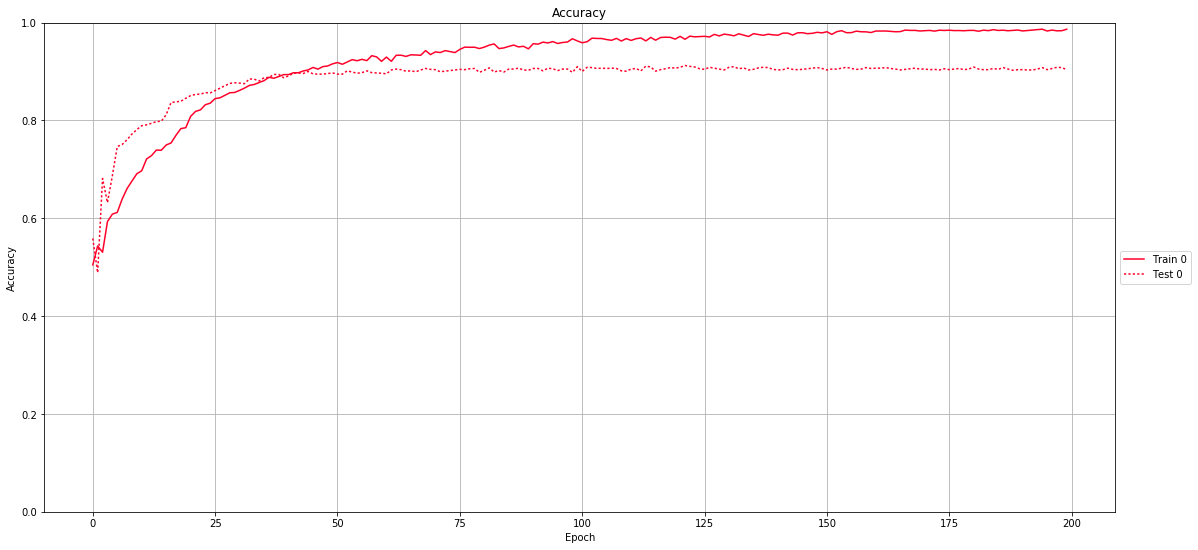

In [15]:
plot_acc(history)

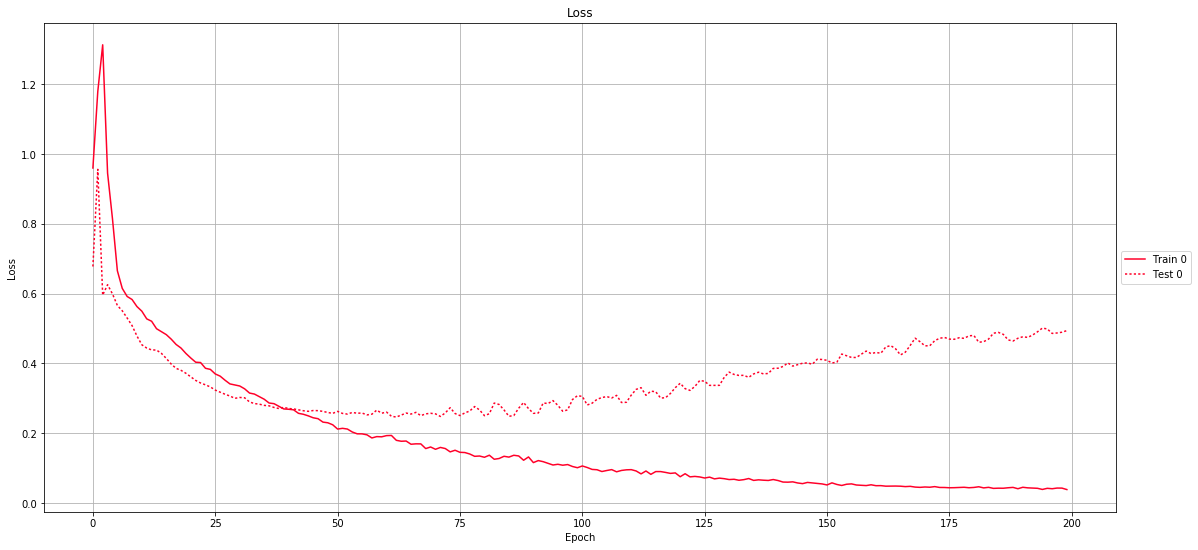

In [16]:
plot_loss(history)

In [17]:
# Viewing the confusion matrix
conf_mat = conf_mat.T  # since rows and cols are interchangeable
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix

Plotting the confusion matrix


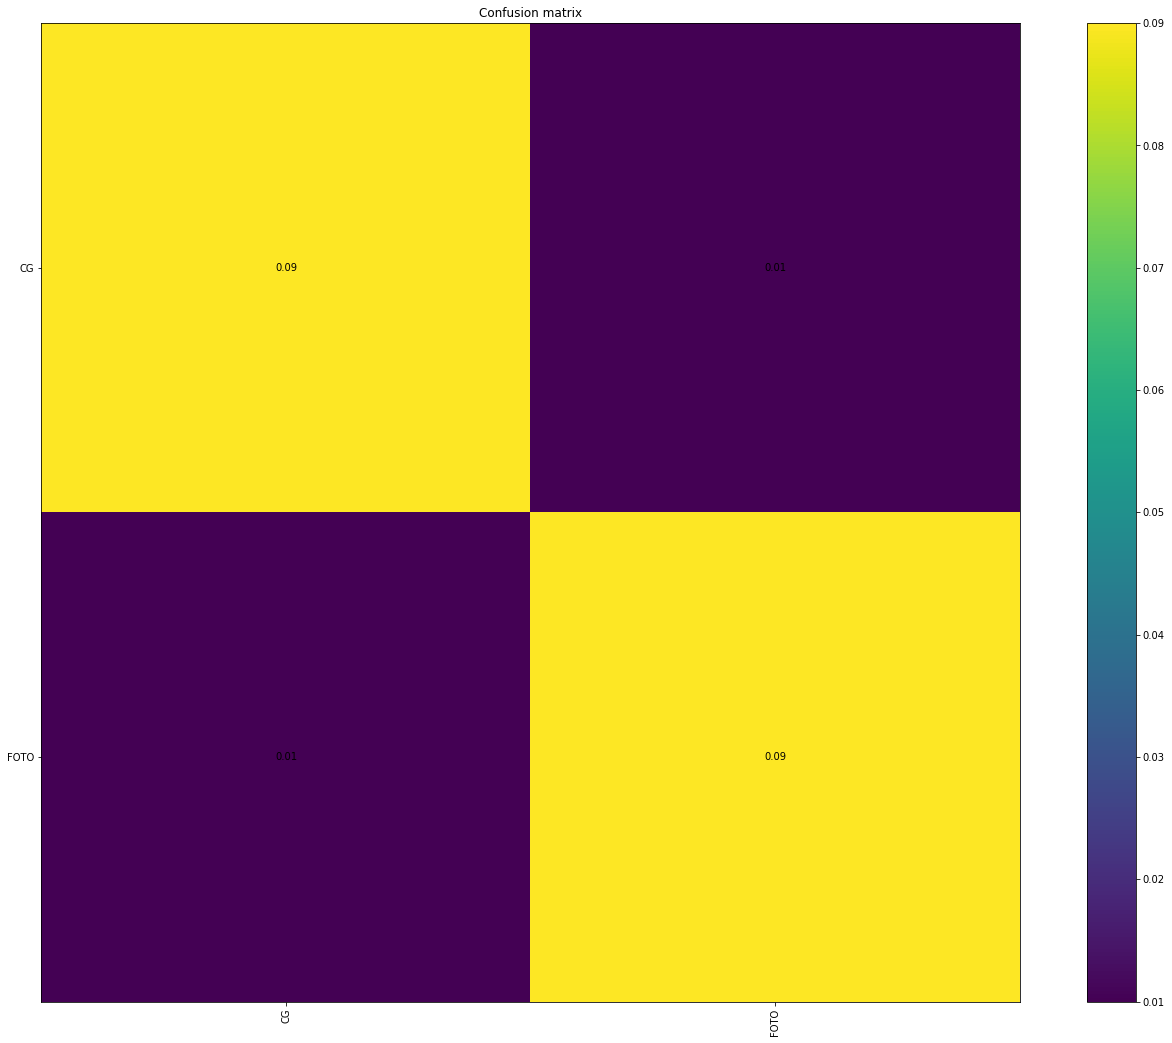

In [18]:
print("Plotting the confusion matrix")
conf_mat = numpy.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(24, 18)
plt.imshow(conf_mat,interpolation='nearest')
for row in xrange(len(list_fams)):
    for col in xrange(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.title('Confusion matrix')
plt.colorbar()
plt.show()